## Image Segmentation

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from sklearn.cluster import MeanShift
import cv2
# Required to calculate Dice Similarity Coefficient

from PIL import Image

# Reduce size of original image to reduce computation time
size = 100, 100

#### Function for displaying images

In [2]:
def plot_two_images(figure_title, image1, label1, image2, label2, 
                    cmap1=None, cmap2=None):
    
    fig = plt.figure()
    fig.suptitle(figure_title)

    # Display the first image
    fig.add_subplot(1, 2, 1)
    plt.imshow(image1, cmap = cmap1)
    plt.axis('off')
    plt.title(label1)

    # Display the second image
    fig.add_subplot(1, 2, 2)
    plt.imshow(image2, cmap = cmap2)
    plt.axis('off')
    plt.title(label2)

    plt.show()

#### Function for applying MeanShift algorithm

In [3]:
def apply_meanshift(img):
    
    # TODO: Apply MeanShift to image
    # Consider the following hints as per the lab specification
    img = np.array(img)
    img = cv2.resize(img, (100, 100))
    # Step 1 - Extract the three RGB colour channels
    channel_r = img[:, :, 0]
    channel_g = img[:, :, 1]
    channel_b = img[:, :, 2]
    
    # Step 2 - Store original image shape to be used later in resizing
    # Combine the three colour channels by flattening each channel
    # Then stack the flattened channels together
    # This gives the "colour_samples"
    r_flatten = channel_r.flatten()
    g_flatten = channel_g.flatten()
    b_flatten = channel_b.flatten()
    colour_samples = np.column_stack([r_flatten, g_flatten, b_flatten])
    
    # Step 3 - Perform MeanShift clustering
    # For larger images this may take a few minutes to compute
    ms_clf = MeanShift(bin_seeding=True)
    ms_labels = ms_clf.fit_predict(colour_samples)

    # Step 4 - Reshape ms_labels back to the original image shape
    # for displaying the segmentation output
    ms_labels = ms_labels.reshape(100, 100)

    return ms_labels

#### Function for applying Watershed algorithm

In [4]:
def apply_watershed(img, threshold, plotDistTransform = False):
    
    # TODO: Apply Watershed to image
    # Consider the following hints as per the lab specification
    img = np.array(img)
    img = cv2.resize(img, (100, 100))
    
    # Convert to binary image (note: can also use cv thresholding)

    # Step 1 - Convert the image to grayscale and then binary
    # and convert the image to a numpy matrix
    img_grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, img_tresh = cv2.threshold(img_grey,threshold - 2 ,threshold , cv2.THRESH_BINARY_INV)
    img_array = img_tresh
    plt.title("img_tresh")
    plt.imshow(img_tresh, 'gray')
    
    # Step 2 - Calculate the distance transform
    # Hint: Use ndi.distance_transform_edt(img_array)
    distance = ndi.distance_transform_edt(img_array)

    # Remember to plot distance transform for Task 2
    plt.title("distance")
    plt.imshow(distance, 'gray')
    
    # Step 3 - Generate the Watershed markers
    # Hint: Use the peak_local_max() function from the skimage.feature library
    # to get the local maximum values and then convert them to markers
    # Remember to change the local search region for good segmentation results
    # using ndi.label() (note the markers are the 0th output of this function)
    local_max = peak_local_max(distance,indices=False,footprint=np.ones((8,8)),labels=img_array)
    markers = ndi.label(local_max)[0]
    
    # Step 4 - Perform Watershed and store the labels
    # Hint: Use the watershed() function from the skimage.morphology library
    # with three inputs: -distance, markers and your image array as a mask
    ws_labels = watershed(-distance, markers, mask=img_array)
    
    return ws_labels, distance

### Q1. Use the MeanShift algorithm for image segmentation

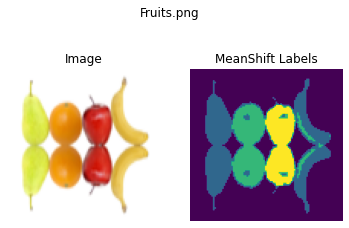

In [5]:
# Specify path to the test image
img_path = 'Fruits.png'

# Read image
img = Image.open(img_path)
img.thumbnail(size)

# Apply MeanShift algorithm to the image
ms_labels = apply_meanshift(img)

# Read and plot the original image and MeanShift result
img = np.array(img)
img = cv2.resize(img, (100, 100))

plot_two_images(img_path, img, "Image", ms_labels, "MeanShift Labels")

### Q2. Use Watershed transformation for image segmentation

<ipython-input-4-2d052697529b>:31: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = peak_local_max(distance,indices=False,footprint=np.ones((8,8)),labels=img_array)


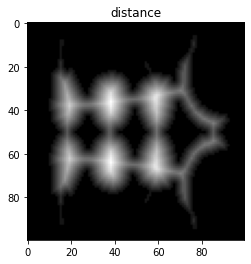

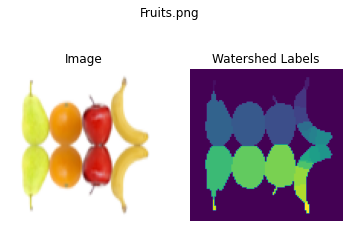

In [6]:
# Read image from img_path as specified above
img = Image.open(img_path)
img.thumbnail(size)

# Apply Watershed algorithm (remember to plot distance transform as well)
ws_labels, distance = apply_watershed(img, threshold=230)

# Read the original image
img = np.array(img)
img = cv2.resize(img, (100, 100))

plot_two_images(img_path, img, "Image", ws_labels, "Watershed Labels")

### Q3. Compare MeanShift and Watershed segmentation results

In [7]:
# List of MaskX.png images
MaskX = ['Mask{}.png'.format(str(idx)) for idx in range(1,9)]

# Generate list of unique MeanShift labels and corresponding label image masks
lbl_ms_unique, lbl_ms_counts = np.unique(ms_labels, return_counts = True)

# Generate list of unique Watershed labels and corresponding label image masks
# Hint: Make sure you have generated reasonable watershed segmentation results
lbl_ws_unique, lbl_ws_counts = np.unique(ws_labels, return_counts = True)

# Iterate over MaskX.png images and calculate DSC
ms_DSCs = []
ws_DSCs = []
for each_maskx_image in MaskX:
    # Read each MaskX.png image
    im1 = Image.open(each_maskx_image)
    im1.thumbnail(size)
    im1 = np.array(im1)
    im1 = cv2.resize(im1, (100, 100))
    im1_unique, im1_counts = np.unique(im1, return_counts = True)
    ground_counts = im1_counts[1: ].sum()
    # Check DSC for each MeanShift label
    label_ms_dsc = []
    for label, label_cnt in zip(lbl_ms_unique, lbl_ms_counts):
        intersection = 0
        row, col = ms_labels.shape
        for i in range(row):
            for j in range(col):
                if im1[i][j] != 0 and ms_labels[i][j] == label:
                    intersection += 1
        DSC  = 2 * (intersection) / (ground_counts + label_cnt)
        label_ms_dsc.append(DSC)
    ms_DSCs.append(max(label_ms_dsc))
    # Check DSC for each Watershed label
    label_ws_dsc = []
    for label, label_cnt in zip(lbl_ws_unique, lbl_ws_counts):
        intersection = 0
        row, col = ws_labels.shape
        for i in range(row):
            for j in range(col):
                if im1[i][j] != 0 and ws_labels[i][j] == label:
                    intersection += 1
        DSC  = 2 * (intersection) / (ground_counts + label_cnt)
        label_ws_dsc.append(DSC)
    ws_DSCs.append(max(label_ws_dsc))
ms_DSCs.append(sum(ms_DSCs)/len(ms_DSCs))
ws_DSCs.append(sum(ws_DSCs)/len(ws_DSCs))
print("Masks", "\t", "MeanShift\t\tWatershed")
for i in range(8):
    print("Mask", i+1, "\t", ms_DSCs[i], "\t", ws_DSCs[i])
print("Avg", "\t", ms_DSCs[8], "\t", ws_DSCs[8])

Masks 	 MeanShift		Watershed
Mask 1 	 0.40101308569016464 	 0.8593903638151426
Mask 2 	 0.5496277915632755 	 0.9289617486338798
Mask 3 	 0.595256312165264 	 0.9034825870646767
Mask 4 	 0.29575021682567215 	 0.28807947019867547
Mask 5 	 0.4050420168067227 	 0.8423114593535749
Mask 6 	 0.5544554455445545 	 0.9177330895795247
Mask 7 	 0.5978593272171254 	 0.9144542772861357
Mask 8 	 0.29739130434782607 	 0.31353135313531355
Avg 	 0.4620494375200756 	 0.7459930436333653


### Conclusion
- By comparing the DSC values of MeanShift and Watershed, it was concluded that the average accuracy of Watershed was higher than that of MeanShift.
- The reason why Watershed is better than Meanshift is that watershed has better response to weak edges, which is the guarantee of generating closed continuous edges.
- In order to solve the problem of image over-segmentation, we can use Gaussian filter for processing.